In [1]:
import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import cudf as gd
import pandas as pd
import numpy as np
import time
from collections import OrderedDict,Counter
from nvstring_workaround import on_gpu
from sklearn.model_selection import KFold
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

## This notebook contains a rapids solution to achieve 0.695 private LB in 12 minutes

### Functions

In [3]:
def rm_cols(gdf,cols):
    gcols = [i for i in gdf.columns]
    for col in cols:
        if col in gcols:
            gdf.drop_column(col)
    return gdf

def reset_col_dtype(gtr,gte):
    for col in gtr.columns:
        a,b = str(gtr[col].dtype),str(gte[col].dtype)
        if a!=b:
            gtr[col] = gtr[col].astype('float32')
            gte[col] = gte[col].astype('float32')
    return gtr,gte

def count_encode(df,cols):
    df['idx'] = np.arange(len(df))
    for col in cols:
        df[col] = df[col].fillna(-999)
        dg = df.groupby(col).agg({col:'count'})
        dg.columns = ['count_%s'%col]
        dg = dg.reset_index()
        df = df.merge(dg,on=[col],how='left')
        df.drop_column(col)
    df = df.sort_values(by='idx')
    df.drop_column('idx')
    df = rm_cols(df,[i for i in df.columns if i.startswith('count_')==0])
    return df

In [4]:
def mtr(tr,col,te):
    tr[col] = tr[col].fillna(-999)
    tr[YCOL] = tr[YCOL].astype('float32')
    dg = tr.groupby(col).agg({YCOL:'mean'})
    dg.columns = ['mtr_%s'%col]
    dg = dg.reset_index()
    te = te.merge(dg,on=[col],how='left')
    del dg
    return te

def mtr_encode(tr,te,cols):
    tr['idx'] = np.arange(len(tr))
    tr['random'] = np.random.random(len(tr))
    tr = tr.sort_values(by='random')
    tr.drop_column('random')
    N = len(tr)//2
    tr1 = tr[:N]
    tr2 = tr[N:]
    te['idx'] = np.arange(len(te))
    for col in cols:
        if col not in tr.columns:
            continue
        tr2 = mtr(tr1,col,tr2)
        tr1 = mtr(tr2,col,tr1)
        te = mtr(tr,col,te)
    if len(tr1.columns)!=len(tr2.columns):
        del tr1,tr2
        return rm_cols(tr,[i for i in tr.columns]),rm_cols(te,[i for i in te.columns])
    del tr
    tr = gd.concat([tr1,tr2])
    tr = tr.sort_values(by='idx')
    tr = rm_cols(tr,[i for i in tr.columns if i.startswith('mtr_')==0])
    del tr1,tr2
    te = te.sort_values(by='idx')
    te = rm_cols(te,[i for i in te.columns if i.startswith('mtr_')==0])
    return tr,te

### Read data

In [5]:
timing_gpu={}

In [6]:
%%time
start = time.time()
step = "read data"

IDCOL = 'MachineIdentifier'
YCOL = 'HasDetections'
PATH = '.'
tr_path = '%s/train.csv'%PATH
te_path = '%s/test.csv'%PATH
gtr = gd.read_csv(tr_path)
gte = gd.read_csv(te_path)

timing_gpu[step] = time.time()-start

CPU times: user 7.39 s, sys: 2.94 s, total: 10.3 s
Wall time: 10.3 s


In [7]:
for col in gtr.columns:
    if gtr[col].dtype=='object':
        gtr[col] = gtr[col].hash_values()
for col in gte.columns:
    if gte[col].dtype=='object':
        gte[col] = gte[col].hash_values()   

### Count encoding

In [8]:
%%time
start = time.time()
step = "count encode"

count_cols = ['CityIdentifier', 'Census_OSBuildRevision', 'Census_TotalPhysicalRAM']
N = len(gtr)
gtr1,gte1 = gtr[count_cols],gte[count_cols]
gtr1,gte1 = reset_col_dtype(gtr1,gte1)
df = gd.concat([gtr1,gte1])
del gtr1,gte1

df = count_encode(df,count_cols)
data = df.to_pandas().values
count_tr,count_te = data[:N],data[N:]
count_cols = ['count_%s'%i for i in count_cols]

timing_gpu[step] = time.time()-start

CPU times: user 6.74 s, sys: 1.58 s, total: 8.31 s
Wall time: 2.68 s


### Target encoding

In [9]:
%%time
start = time.time()
step = "target encode"

mtr_cols = ['SmartScreen']
gtr1 = gtr[mtr_cols+[YCOL]] 
gte1 = gte[mtr_cols]

gtr1,gte1 = mtr_encode(gtr1,gte1,mtr_cols)
mtr_tr,mtr_te = gtr1.to_pandas(),gte1.to_pandas()
mtr_cols = [i for i in mtr_tr.columns]
mtr_tr,mtr_te = mtr_tr.values,mtr_te.values
del gtr1,gte1

timing_gpu[step] = time.time()-start

CPU times: user 4.54 s, sys: 688 ms, total: 5.22 s
Wall time: 1.85 s


#### target encode will be much faster if the column has many levels. Unfortunately 'SmartScreen' only has several levels.

### remove columns & combine all features

In [10]:
%%time
start = time.time()
step = "combine"

badcols = ['PuaMode','OsSuite','ProductName','SmartScreen']
y = gtr[YCOL].to_pandas().values

gtr = rm_cols(gtr,[IDCOL,YCOL]+badcols)
gte = rm_cols(gte,[IDCOL,YCOL]+badcols)

tr = gtr.to_pandas()
te = gte.to_pandas()

cols = [i for i in tr.columns]
tr,te = tr.values,te.values

train = np.hstack([tr,count_tr,mtr_tr])
test = np.hstack([te,count_te,mtr_te])
cols = cols + count_cols + mtr_cols

print(train.shape, test.shape)
#print(cols)
timing_gpu[step] = time.time()-start

(8921483, 81) (7853253, 81)
CPU times: user 5min 46s, sys: 2min 24s, total: 8min 10s
Wall time: 15.5 s


In [11]:
xgb_params =  {
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'eta':0.1,
        'nthread': 16,
        'max_depth': 10,
        'silent':1,
        'subsample':0.8,
        'colsample_bytree': 0.7,
        'min_child_weight':10,
        'eval_metric':'auc',
}

xgb_gpu_params = xgb_params.copy()
xgb_gpu_params.update({'tree_method': 'gpu_hist',})

### Train & Predict

In [12]:
%%time
start = time.time()
step = "train & predict"

feature_names = cols
pred = 0
kf = KFold(n_splits=4, shuffle=True, random_state=42)
for i,(train_index, test_index) in enumerate(kf.split(train)):
    y_train,y_test = y[train_index],y[test_index]
    X_train,X_test = train[train_index],train[test_index]
    watchlist = ()
    dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=feature_names)
    dtest = xgb.DMatrix(data=test, feature_names=feature_names)
    clf = xgb.train(xgb_gpu_params, dtrain=dtrain,
                num_boost_round=500,evals=watchlist,
                early_stopping_rounds=None,maximize=True,
                verbose_eval=100)
    pred += clf.predict(dtest)
    print('fold',i,'done')
pred /= (i+1)

timing_gpu[step] = time.time()-start

fold 0 done
fold 1 done
fold 2 done
fold 3 done
CPU times: user 6min 46s, sys: 3min 24s, total: 10min 10s
Wall time: 10min 13s


### Summary

In [15]:
#sub = pd.read_csv('%s/sample_submission.csv'%PATH)
#sub[YCOL] = pred
#sub.to_csv('rapids_sub.csv.gz',index=False,compression='gzip')

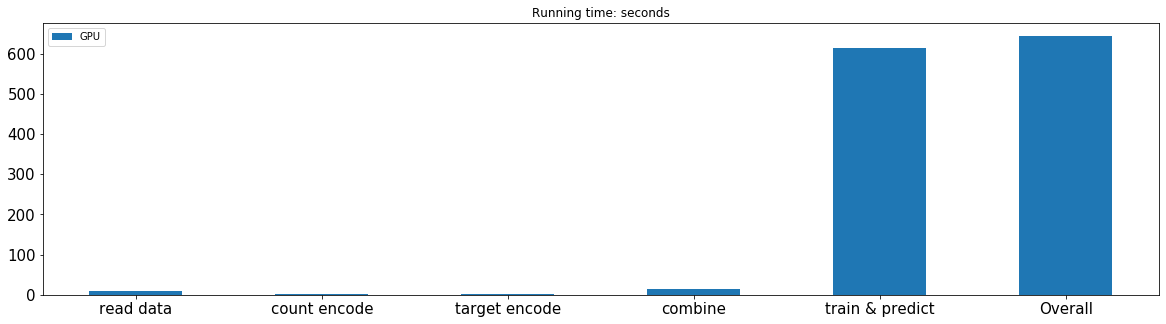

In [16]:
steps = ['read data','count encode','target encode','combine','train & predict']
GPU_RUN_TIME = timing_gpu
GPU_RUN_TIME['Overall'] = sum([GPU_RUN_TIME[i] for i in steps])
steps.append('Overall')
gpu_time = [GPU_RUN_TIME[i] for i in steps]
df = pd.DataFrame({'GPU': gpu_time}, index=steps)
df.plot.bar(rot=0,figsize=(20,5), fontsize=15, title='Running time: seconds')